In [5]:
# IMPORT LIBRARIES

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Flatten,
    Dense, Dropout, GlobalAveragePooling2D
)
from tensorflow.keras.applications import (
    VGG16, ResNet50, MobileNet, InceptionV3, EfficientNetB0
)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [6]:
# LOAD THE DATA

import os

base_dir = r"D:\DS PROJECTS SUBMISSION\Multiclass_Fish_Image_Classification\Dataset\images.cv_jzk6llhf18tm3k0kyttxz\data"

print("Inside Dataset folder:")
print(os.listdir(base_dir))

print("Dataset extracted successfully!")


Inside Dataset folder:
['test', 'train', 'val']
Dataset extracted successfully!


In [7]:
# DATA RESCALING

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)

In [8]:
# GENERATORS

train_generator = train_datagen.flow_from_directory(
    r"D:\WORKOUTS\DATA_CLEANING\Dataset CSV\MINI PROJECT 5\Dataset\images.cv_jzk6llhf18tm3k0kyttxz\data\train",
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    r"D:\WORKOUTS\DATA_CLEANING\Dataset CSV\MINI PROJECT 5\Dataset\images.cv_jzk6llhf18tm3k0kyttxz\data\val",
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)

print(train_generator.samples)
print(val_generator.samples)

NUM_CLASSES = train_generator.num_classes
print("Classes:", train_generator.class_indices)


Found 6225 images belonging to 11 classes.
Found 1092 images belonging to 11 classes.
6225
1092
Classes: {'animal fish': 0, 'animal fish bass': 1, 'fish sea_food black_sea_sprat': 2, 'fish sea_food gilt_head_bream': 3, 'fish sea_food hourse_mackerel': 4, 'fish sea_food red_mullet': 5, 'fish sea_food red_sea_bream': 6, 'fish sea_food sea_bass': 7, 'fish sea_food shrimp': 8, 'fish sea_food striped_red_mullet': 9, 'fish sea_food trout': 10}


In [14]:
# TRAIN THE MODEL

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),

    Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_97 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_98 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_99 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,170,379 (42.61 MB)

 Trainable params: 11,170,379 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# FUNCTION FOR PRETRAINED MODELS

def build_pretrained_model(base_model, num_classes):
    base_model.trainable = False   # Freeze pretrained weights

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)

    # ✅ MULTI-CLASS OUTPUT
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [16]:
# LOAD TRAINED MODELS (COMPARISON)

vgg_model = build_pretrained_model(
    VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3)),
    NUM_CLASSES
)

resnet_model = build_pretrained_model(
    ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3)),
    NUM_CLASSES
)

mobilenet_model = build_pretrained_model(
    MobileNet(weights='imagenet', include_top=False, input_shape=(224,224,3)),
    NUM_CLASSES
)

inception_model = build_pretrained_model(
    InceptionV3(weights='imagenet', include_top=False, input_shape=(224,224,3)),
    NUM_CLASSES
)

efficientnet_model = build_pretrained_model(
    EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3)),
    NUM_CLASSES
)


In [17]:
# SAVE BEST MODEL

checkpoint = ModelCheckpoint(
    "best_model.h5",
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)


In [18]:
# TRAIN THE BEST MODEL

# EfficientNet
checkpoint_eff = ModelCheckpoint(
    "best_efficientnet.h5",
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

history_efficientnet = efficientnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=3,
    callbacks=[checkpoint_eff, early_stop]
)

# VGG16
checkpoint_vgg = ModelCheckpoint(
    "best_vgg16.h5",
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

history_vgg = vgg_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=3,
    callbacks=[checkpoint_vgg, early_stop]
)

# ResNet50
checkpoint_resnet = ModelCheckpoint(
    "best_resnet50.h5",
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

history_resnet = resnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=3,
    callbacks=[checkpoint_resnet, early_stop]
)


# MobileNet
checkpoint_mobilenet = ModelCheckpoint(
    "best_mobilenet.h5",
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

history_mobilenet = mobilenet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=3,
    callbacks=[checkpoint_mobilenet, early_stop]
)


# InceptionV3
checkpoint_inception = ModelCheckpoint(
    "best_inception.h5",
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

history_inception = inception_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=3,
    callbacks=[checkpoint_inception, early_stop]
)


print("Training complete!")


Epoch 1/3
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1571 - loss: 2.3647
Epoch 1: val_accuracy improved from None to 0.17125, saving model to best_efficientnet.h5



Epoch 1: finished saving model to best_efficientnet.h5
195/195 ━━━━━━━━━━━━━━━━━━━━ 496s 2s/step - accuracy: 0.1611 - loss: 2.3430 - val_accuracy: 0.1712 - val_loss: 2.3174
Epoch 2/3
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1568 - loss: 2.3204
Epoch 2: val_accuracy did not improve from 0.17125
195/195 ━━━━━━━━━━━━━━━━━━━━ 345s 2s/step - accuracy: 0.1692 - loss: 2.3185 - val_accuracy: 0.1712 - val_loss: 2.3101
Epoch 3/3
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1793 - loss: 2.3072
Epoch 3: val_accuracy did not improve from 0.17125
195/195 ━━━━━━━━━━━━━━━━━━━━ 346s 2s/step - accuracy: 0.1761 - loss: 2.3077 - val_accuracy: 0.1712 - val_loss: 2.3131
Restoring model weights from the end of the best epoch: 2.
Epoch 1/3
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3329 - loss: 1.9826
Epoch 1: val_accuracy improved from None to 0.73352, saving model to best_vgg16.h5



Epoch 1: finished saving model to best_vgg16.h5
195/195 ━━━━━━━━━━━━━━━━━━━━ 1771s 9s/step - accuracy: 0.4683 - loss: 1.6390 - val_accuracy: 0.7335 - val_loss: 1.0808
Epoch 2/3
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.6749 - loss: 1.0552
Epoch 2: val_accuracy improved from 0.73352 to 0.87454, saving model to best_vgg16.h5



Epoch 2: finished saving model to best_vgg16.h5
195/195 ━━━━━━━━━━━━━━━━━━━━ 2248s 12s/step - accuracy: 0.7033 - loss: 0.9673 - val_accuracy: 0.8745 - val_loss: 0.6770
Epoch 3/3
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7633 - loss: 0.7736
Epoch 3: val_accuracy improved from 0.87454 to 0.89286, saving model to best_vgg16.h5



Epoch 3: finished saving model to best_vgg16.h5
195/195 ━━━━━━━━━━━━━━━━━━━━ 2147s 11s/step - accuracy: 0.7849 - loss: 0.7110 - val_accuracy: 0.8929 - val_loss: 0.4905
Restoring model weights from the end of the best epoch: 3.
Epoch 1/3
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.1572 - loss: 2.4052
Epoch 1: val_accuracy improved from None to 0.17125, saving model to best_resnet50.h5



Epoch 1: finished saving model to best_resnet50.h5
195/195 ━━━━━━━━━━━━━━━━━━━━ 812s 4s/step - accuracy: 0.1690 - loss: 2.3202 - val_accuracy: 0.1712 - val_loss: 2.2321
Epoch 2/3
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.1814 - loss: 2.2289
Epoch 2: val_accuracy improved from 0.17125 to 0.19963, saving model to best_resnet50.h5



Epoch 2: finished saving model to best_resnet50.h5
195/195 ━━━━━━━━━━━━━━━━━━━━ 835s 4s/step - accuracy: 0.1846 - loss: 2.2227 - val_accuracy: 0.1996 - val_loss: 2.1801
Epoch 3/3
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1976 - loss: 2.1739
Epoch 3: val_accuracy improved from 0.19963 to 0.22894, saving model to best_resnet50.h5



Epoch 3: finished saving model to best_resnet50.h5
195/195 ━━━━━━━━━━━━━━━━━━━━ 789s 4s/step - accuracy: 0.1973 - loss: 2.1711 - val_accuracy: 0.2289 - val_loss: 2.1019
Restoring model weights from the end of the best epoch: 1.
Epoch 1/3
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6519 - loss: 1.1021
Epoch 1: val_accuracy improved from None to 0.97344, saving model to best_mobilenet.h5



Epoch 1: finished saving model to best_mobilenet.h5
195/195 ━━━━━━━━━━━━━━━━━━━━ 320s 2s/step - accuracy: 0.8182 - loss: 0.5828 - val_accuracy: 0.9734 - val_loss: 0.0975
Epoch 2/3
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9400 - loss: 0.1840
Epoch 2: val_accuracy improved from 0.97344 to 0.97894, saving model to best_mobilenet.h5



Epoch 2: finished saving model to best_mobilenet.h5
195/195 ━━━━━━━━━━━━━━━━━━━━ 305s 2s/step - accuracy: 0.9489 - loss: 0.1567 - val_accuracy: 0.9789 - val_loss: 0.0605
Epoch 3/3
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9677 - loss: 0.1054
Epoch 3: val_accuracy improved from 0.97894 to 0.98168, saving model to best_mobilenet.h5



Epoch 3: finished saving model to best_mobilenet.h5
195/195 ━━━━━━━━━━━━━━━━━━━━ 303s 2s/step - accuracy: 0.9700 - loss: 0.0988 - val_accuracy: 0.9817 - val_loss: 0.0503
Restoring model weights from the end of the best epoch: 3.
Epoch 1/3
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6307 - loss: 1.1889
Epoch 1: val_accuracy improved from None to 0.90018, saving model to best_inception.h5



Epoch 1: finished saving model to best_inception.h5
195/195 ━━━━━━━━━━━━━━━━━━━━ 544s 3s/step - accuracy: 0.7635 - loss: 0.7407 - val_accuracy: 0.9002 - val_loss: 0.2824
Epoch 2/3
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8674 - loss: 0.4025
Epoch 2: val_accuracy improved from 0.90018 to 0.95421, saving model to best_inception.h5



Epoch 2: finished saving model to best_inception.h5
195/195 ━━━━━━━━━━━━━━━━━━━━ 508s 3s/step - accuracy: 0.8848 - loss: 0.3463 - val_accuracy: 0.9542 - val_loss: 0.1571
Epoch 3/3
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8993 - loss: 0.2905
Epoch 3: val_accuracy improved from 0.95421 to 0.95513, saving model to best_inception.h5



Epoch 3: finished saving model to best_inception.h5
195/195 ━━━━━━━━━━━━━━━━━━━━ 506s 3s/step - accuracy: 0.9049 - loss: 0.2723 - val_accuracy: 0.9551 - val_loss: 0.1356
Restoring model weights from the end of the best epoch: 1.
Training complete!


In [19]:
# BEST MODEL

model_results = {
    "EfficientNetB0": max(history_efficientnet.history['val_accuracy']),
    "VGG16": max(history_vgg.history['val_accuracy']),
    "ResNet50": max(history_resnet.history['val_accuracy']),
    "MobileNet": max(history_mobilenet.history['val_accuracy']),
    "InceptionV3": max(history_inception.history['val_accuracy'])
}

best_model_name = max(model_results, key=model_results.get)
best_accuracy = model_results[best_model_name]

print("Best Model:", best_model_name)
print("Best Validation Accuracy:", best_accuracy)


Best Model: MobileNet
Best Validation Accuracy: 0.9816849827766418


In [20]:
# CHECK TRAIN VS VAL ACCURACY

print("Train Acc:", max(history_mobilenet.history['accuracy']))
print("Val Acc:", max(history_mobilenet.history['val_accuracy']))


Train Acc: 0.9699598550796509
Val Acc: 0.9816849827766418


In [21]:
# FINE TUNING

mobilenet_model.trainable = True

for layer in mobilenet_model.layers[:-20]:
    layer.trainable = False

mobilenet_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

fine_tune_history = mobilenet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    callbacks=[checkpoint_mobilenet, early_stop]
)

Epoch 1/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9716 - loss: 0.0883
Epoch 1: val_accuracy improved from 0.98168 to 0.99176, saving model to best_mobilenet.h5



Epoch 1: finished saving model to best_mobilenet.h5
195/195 ━━━━━━━━━━━━━━━━━━━━ 320s 2s/step - accuracy: 0.9725 - loss: 0.0852 - val_accuracy: 0.9918 - val_loss: 0.0335
Epoch 2/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9789 - loss: 0.0723
Epoch 2: val_accuracy improved from 0.99176 to 0.99267, saving model to best_mobilenet.h5



Epoch 2: finished saving model to best_mobilenet.h5
195/195 ━━━━━━━━━━━━━━━━━━━━ 320s 2s/step - accuracy: 0.9782 - loss: 0.0700 - val_accuracy: 0.9927 - val_loss: 0.0290
Epoch 3/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9826 - loss: 0.0608
Epoch 3: val_accuracy improved from 0.99267 to 0.99451, saving model to best_mobilenet.h5



Epoch 3: finished saving model to best_mobilenet.h5
195/195 ━━━━━━━━━━━━━━━━━━━━ 315s 2s/step - accuracy: 0.9825 - loss: 0.0605 - val_accuracy: 0.9945 - val_loss: 0.0267
Epoch 4/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9822 - loss: 0.0548
Epoch 4: val_accuracy did not improve from 0.99451
195/195 ━━━━━━━━━━━━━━━━━━━━ 283s 1s/step - accuracy: 0.9827 - loss: 0.0554 - val_accuracy: 0.9945 - val_loss: 0.0261
Epoch 5/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9804 - loss: 0.0589
Epoch 5: val_accuracy improved from 0.99451 to 0.99542, saving model to best_mobilenet.h5



Epoch 5: finished saving model to best_mobilenet.h5
195/195 ━━━━━━━━━━━━━━━━━━━━ 284s 1s/step - accuracy: 0.9815 - loss: 0.0575 - val_accuracy: 0.9954 - val_loss: 0.0245
Restoring model weights from the end of the best epoch: 5.


In [22]:
# BEST MODEL

best_model = tf.keras.models.load_model("best_mobilenet.h5")


In [23]:
# GET TRUE LABELS & PREDICTIONS

# LOAD BEST MODEL (MobileNet)
best_model = tf.keras.models.load_model("best_mobilenet.h5")

# RESET GENERATOR
val_generator.reset()

# PREDICT
y_pred_prob = best_model.predict(val_generator)
y_pred = np.argmax(y_pred_prob, axis=1)

# TRUE LABELS
y_true = val_generator.classes

35/35 ━━━━━━━━━━━━━━━━━━━━ 31s 836ms/step


In [24]:
# EVALUATION METRICS

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Accuracy: 0.08333333333333333
Precision: 0.08296495299596955
Recall: 0.08333333333333333
F1-score: 0.08314722577351684


[[26  1 21 18 21 14 19 15 16 21 15]
 [ 1  0  1  2  1  2  0  1  1  1  0]
 [18  0  7  9 12  9 12  9  8 10 11]
 [16  2  8  3 11  8  8  7 13  9  9]
 [14  0  9  8  8  6  9 13  9  9 12]
 [16  3  9 11  6  8 13  6  4  8  6]
 [26  0  9  9  8 12  8 10 12  8 11]
 [16  0 11  9  8  6 10  8 10 12  7]
 [23  1  9  6  3 11 12  7  9  8 11]
 [16  0 11 11 10  9  8 12  8  7  9]
 [18  0 10  8 10  4 14  9 10  8  7]]


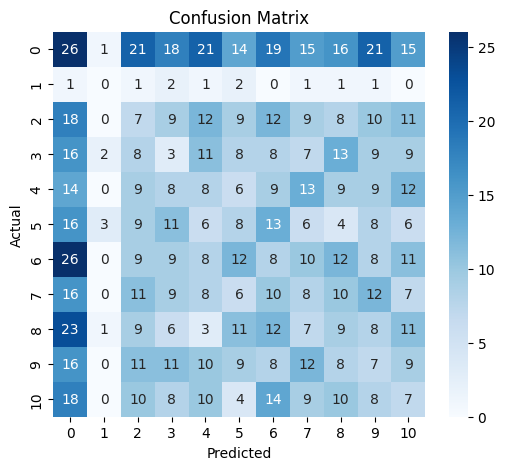

In [25]:
# CONFUSION MATRIX

cm = confusion_matrix(y_true, y_pred)
print(cm)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [26]:
# STORE METRICS

results = []

results.append({
    "Model": "CNN_Model_1",
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1-score": f1
})

results_df = pd.DataFrame(results)
print(results_df)

         Model  Accuracy  Precision    Recall  F1-score
0  CNN_Model_1  0.083333   0.082965  0.083333  0.083147


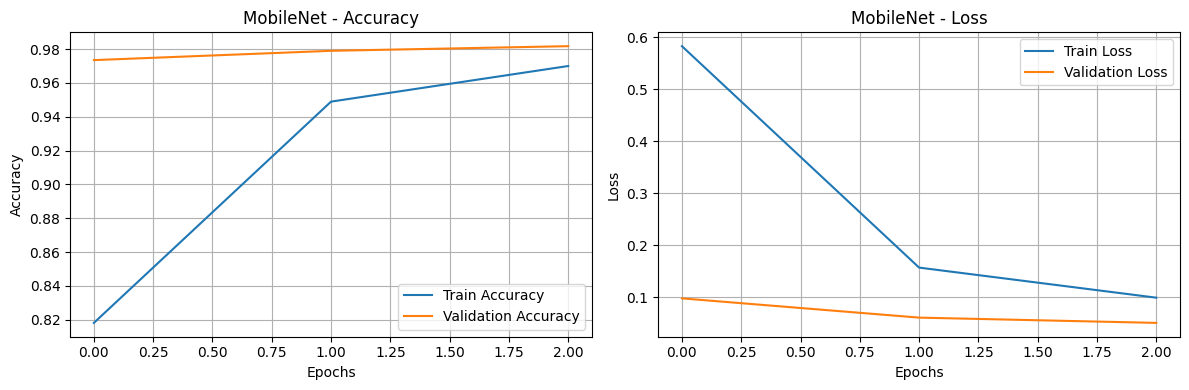

In [27]:
# VISUALIZE TRAINING HISTORY (ACCURACY AND LOSS)

def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 4))

    # -------- ACCURACY --------
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # -------- LOSS --------
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history_mobilenet, "MobileNet")

In [28]:
# SAVE THE MODEL

best_model.save("best_mobilenet.h5")

In [29]:
# SAVE CLASS NAMES

import json

class_names = list(train_generator.class_indices.keys())

with open("class_names.json", "w") as f:
    json.dump(class_names, f)

print("Saved class_names.json")


Saved class_names.json


In [32]:
# TEST SCALING AND GENERATORS

from tensorflow.keras.applications.mobilenet import preprocess_input

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

test_generator = test_datagen.flow_from_directory(
    r"D:\DS PROJECTS SUBMISSION\Multiclass_Fish_Image_Classification\Dataset\images.cv_jzk6llhf18tm3k0kyttxz\data\test",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 3187 images belonging to 11 classes.


In [33]:
# FINAL TEST SCORE

test_loss, test_accuracy = best_model.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)
print("Test Loss:", test_loss)

100/100 ━━━━━━━━━━━━━━━━━━━━ 103s 990ms/step - accuracy: 0.9906 - loss: 0.0244
Test Accuracy: 0.9905867576599121
Test Loss: 0.024425452575087547
